In [ ]:
import numpy as np
from scipy.linalg import eigh
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Constants
hbar = 1.0  # Reduced Planck's constant
N = 100     # Number of grid points
L = 10.0    # Length of the 1D box
x = np.linspace(-L / 2, L / 2, N)  # Spatial grid
dx = x[1] - x[0]  # Grid spacing

def potential_harmonic(x, k):
    """Harmonic potential: V(x) = 0.5 * k * x^2"""
    return 0.5 * k * x**2

def solve_schrodinger_1d(m, k):
    """Solve the 1D Schrödinger equation for a harmonic oscillator."""
    V = potential_harmonic(x, k)  # Potential
    kinetic = -0.5 * (hbar**2 / m) * (-2 * np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)) / dx**2
    H = kinetic + np.diag(V)  # Hamiltonian
    
    # Solve eigenvalue problem
    eigenvalues, _ = eigh(H)
    return eigenvalues[:5]  # Return first 5 energy levels

In the above cell is the code to turn the hamiltonian function for a 1D Harmonic Oscillator to a matrix. This is done so as to turn the differential equation (Here, Shrodinger Equation) to difference equation to get the numerical solutions. After that by remembering the equation  H(psi) = E(psi), i.e. eigenvalues of matrix H are the allowed energy levels, we found out the first 5 allowed energy levels in the 1D oscillator for the given (m,k) combination.
***

In [ ]:
# Generate dataset
data = []
m_values = np.arange(0.1, 50, 0.2) # Range of masses
k_values = np.arange(0.1, 50, 0.2)  # Range of spring constants

for m in m_values:
    for k in k_values:
        energies = solve_schrodinger_1d(m, k)
        data.append([m, k] + list(energies))

As we decided to do this project by our own from scratch, hence such kind of large dataset with mass, spring const., and labeled numrical solution for 1D harmonic oscillator was very difficult to find. Hence we have decided to make our own dataset for training the ML models.
***

In [35]:
# Convert to a Pandas DataFrame
columns = ['mass', 'spring_constant'] + [f'energy_{i+1}' for i in range(5)]
df = pd.DataFrame(data, columns=columns)
print(df.head())

# Save dataset
df.to_csv('quantum_data.csv', index=False)

   mass  spring_constant  energy_1  energy_2  energy_3   energy_4   energy_5
0   0.1              0.1  0.634374  2.253990  4.669856   7.996048  12.254691
1   0.1              0.3  0.907159  2.915330  5.479934   8.847789  13.117653
2   0.1              0.5  1.134268  3.511434  6.272234   9.708487  13.994845
3   0.1              0.7  1.330011  4.051910  7.035849  10.569426  14.882987
4   0.1              0.9  1.503287  4.545650  7.765934  11.422959  15.778276


Converting the dataset to a csv file for later use.
***

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [5]:
# Load data
data = pd.read_csv('quantum_data.csv')

# Define features and targets
X = data[['mass', 'spring_constant']]
y = data[[f'energy_{i+1}' for i in range(5)]]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Divinding the dataset into 80% trainig and 20% test.
***

***
First using 2 simple ML models XGBoost and Random Forest regression to train on the dataset and predict the first 5 allowed energy levels

In [6]:
# Initialize a multi-output regressor
multi_output_model = MultiOutputRegressor(GradientBoostingRegressor())

# Train the model
multi_output_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [7]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [8]:
# Predictions from XGBoost
y_pred_xgb = multi_output_model.predict(X_test)

# Predictions from Random Forest
y_pred_rf = rf_model.predict(X_test)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
# Evaluate XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Evaluate Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print results
print("XGBoost Results:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"R^2 Score: {r2_xgb}")

print("\nRandom Forest Results:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")


XGBoost Results:
Mean Squared Error: 0.0130166380138186
R^2 Score: 0.9991812899868193

Random Forest Results:
Mean Squared Error: 0.00033504664801053643
R^2 Score: 0.9999782679376749


As we can see the Random Forest model outperformed XGBoost significantly in both mse and R^2 score. The MSE values of RF model was approximately 1/100 of that of the XGBoost one. Meanwhile the R^2 score which tells us the explained variance by the models is also greater for Random Forest although not by that much
***

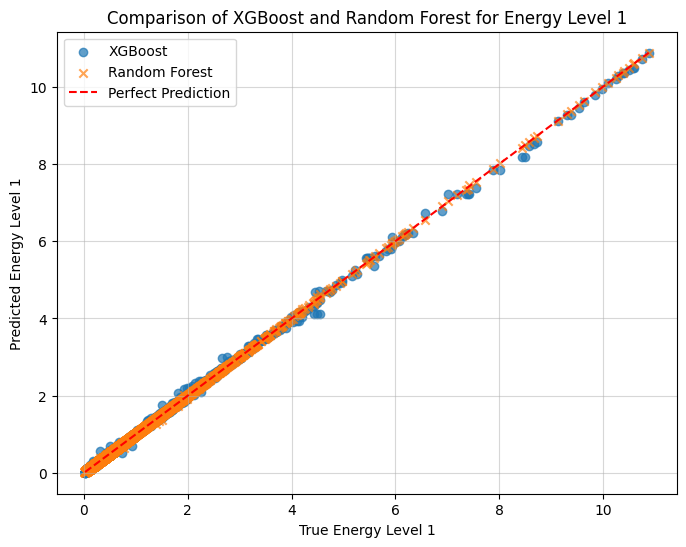

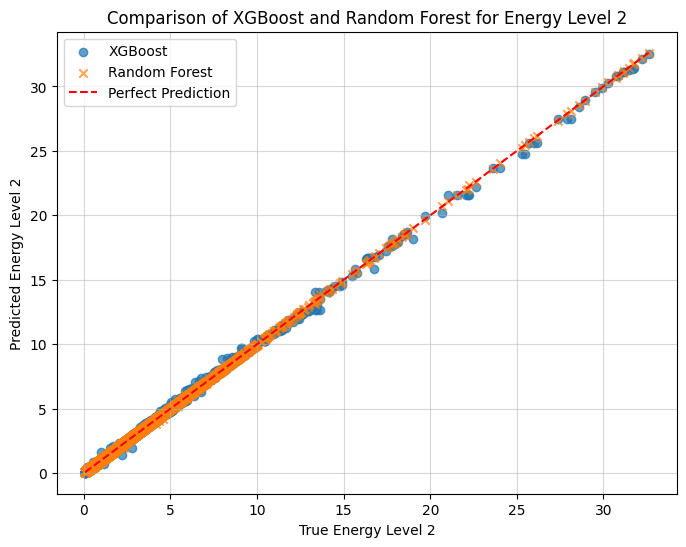

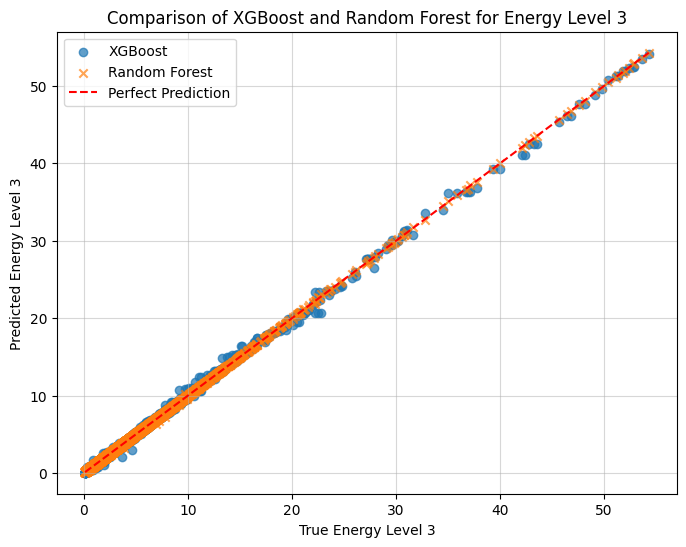

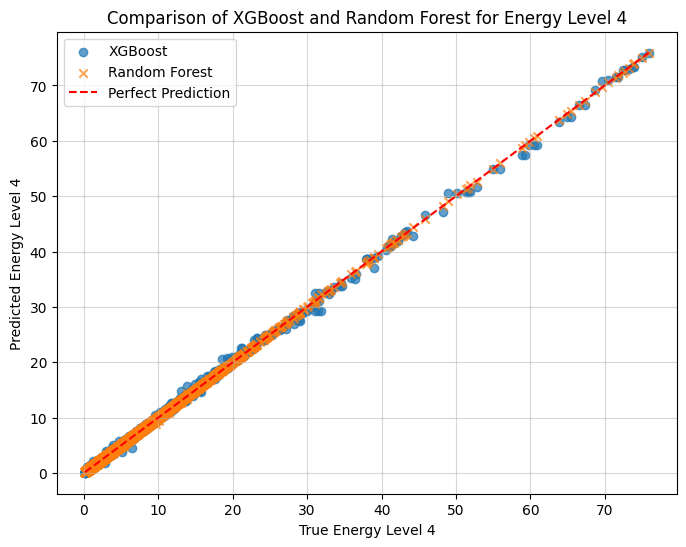

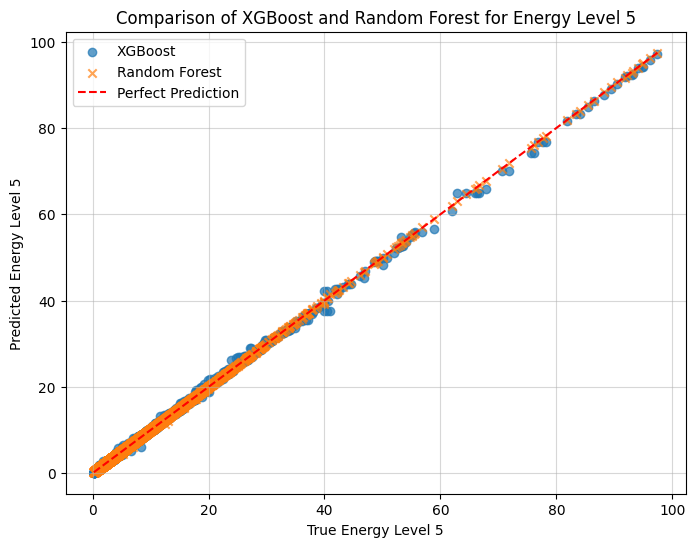

In [11]:
# Loop through all energy levels (assuming there are 5 energy levels)
for i in range(5):
    plt.figure(figsize=(8, 6))
    true_values = y_test[f'energy_{i+1}']
    plt.scatter(true_values, y_pred_xgb[:, i], label='XGBoost', alpha=0.7, marker='o')
    plt.scatter(true_values, y_pred_rf[:, i], label='Random Forest', alpha=0.7, marker='x')
    plt.plot(
        [min(true_values), max(true_values)],
        [min(true_values), max(true_values)],
        color='red', linestyle='--', label='Perfect Prediction'
    )
    plt.xlabel(f"True Energy Level {i+1}")
    plt.ylabel(f"Predicted Energy Level {i+1}")
    plt.title(f"Comparison of XGBoost and Random Forest for Energy Level {i+1}")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

One common theme which we can observe in all the above plots is the at lower energy values for all 5 levels, XGBoost and Random Forest closely follow the perfect prediction line. But as the energy increases XGBoost tends to deviate a little from the perfect prediction line whereas Random Forest still closely follow the perfect prediction line even at higher energies. This can be attributed to the fact that the synthetic dataset that we created had lesser training cases of very large k along with very small m. Now since the numerical solution for the energy levels approximately changes linearly with omega = sqrt(k/m), as the analytical solutions are E = (n+1/2) *hcross *omega, because of this lower number of training cases XGBoost lacks in better prediction for higher energy (large k, small m) cases. But as Random Forest trains by building trees independently (in parallel) using a simple averaging unlike XGBoost which builds trees sequentially, it tends to train faster. Hence even at higer energies it performs good.
***

In [12]:
def analytical_energy_levels(m, k, hbar=1):
    omega = np.sqrt(k / m)
    return [hbar * omega * (n + 0.5) for n in range(5)]  # First 5 energy levels


This is the analytical solution of the energy levels of a 1D harmonic oscillator
***

In [ ]:
# Define an example sample system
m = 10.0  # Mass
k = 18.0  # Spring constant

feature_names = ['mass', 'spring_constant']
sample_input = pd.DataFrame([[m, k]], columns=feature_names)

# Get results
analytical = analytical_energy_levels(m, k)
numerical = solve_schrodinger_1d(m, k)
predicted_XGB = multi_output_model.predict(sample_input)[0]
predicted_RF = rf_model.predict(sample_input)[0]

# Print comparison
print("Energy Level Comparison:")
print(f"Analytical: {analytical}")
print(f"Numerical:  {numerical}")
print(f"Predicted:  {predicted_XGB}")
print(f"Predicted:  {predicted_RF}")

Energy Level Comparison:
Analytical: [np.float64(0.6708203932499369), np.float64(2.0124611797498106), np.float64(3.3541019662496847), np.float64(4.695742752749559), np.float64(6.037383539249432)]
Numerical:  [0.66503077 1.98330308 3.27765928 4.54738988 5.79171074]
Predicted:  [0.63970839 1.93694922 3.22714183 4.47945204 5.63249457]
Predicted:  [0.66671791 1.98842992 3.28636142 4.55981327 5.8080135 ]


Taking an example case of m=10 and k=18 for comapring the results of XGBoost and Random Forest with the analytical and numerical solutions.
***

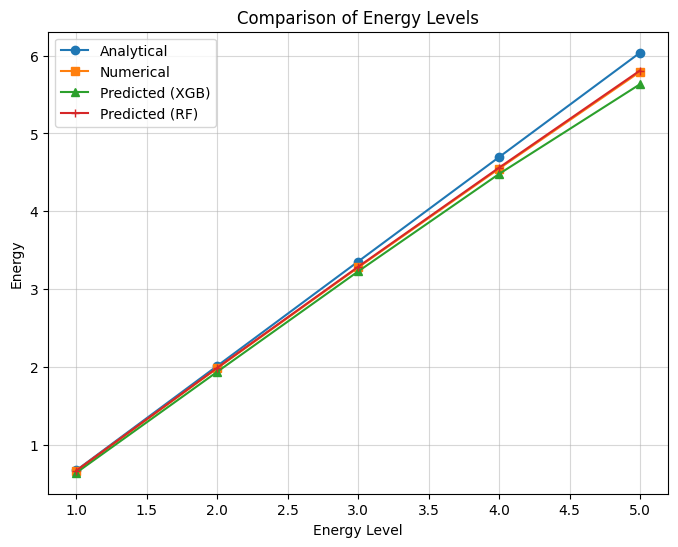

In [14]:
# Plot comparison
levels = range(1, 6)
plt.figure(figsize=(8, 6))
plt.plot(levels, analytical, label='Analytical', marker='o')
plt.plot(levels, numerical, label='Numerical', marker='s')
plt.plot(levels, predicted_XGB, label='Predicted (XGB)', marker='^')
plt.plot(levels, predicted_RF, label='Predicted (RF)', marker='+')
plt.xlabel("Energy Level")
plt.ylabel("Energy")
plt.title("Comparison of Energy Levels")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


Here also we can confirm that Random Forest follows closely the numrical solutions while XGBoost deviates a little from it. The numerical solution itself deviates from analytical solutions which was expected as numerical solutions are only an approximation of the analytical ones
***

In [68]:
import numpy as np
import pandas as pd

# Generate omega values
omega_values = np.arange(0.1, 50, 0.2)

# Generate valid m and k for all omega values
m_values = np.random.uniform(0.1, 50, len(omega_values))
k_values = m_values * omega_values**2
valid_indices = (k_values >= 0.1) & (k_values <= 50)

# Filter valid omega, m, and k
omega_values = omega_values[valid_indices]
m_values = m_values[valid_indices]
k_values = k_values[valid_indices]

# Prepare input features for predictions
feature_names = ['mass', 'spring_constant']
input_features = pd.DataFrame({'mass': m_values, 'spring_constant': k_values})

Creating test dataset with one case of k and m for each omega to avoid redundancy (as k=1,m=1 and k=2,m=2 gives same omega). This dataset will be used to analyze the performance of the models for varying omega in ground state alone.
***

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
C:\Users\divya\AppData\Local\Temp\ipykernel_5444\1744483943.py:18: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Comparison of Energy Level 1 for Different $\omega$")


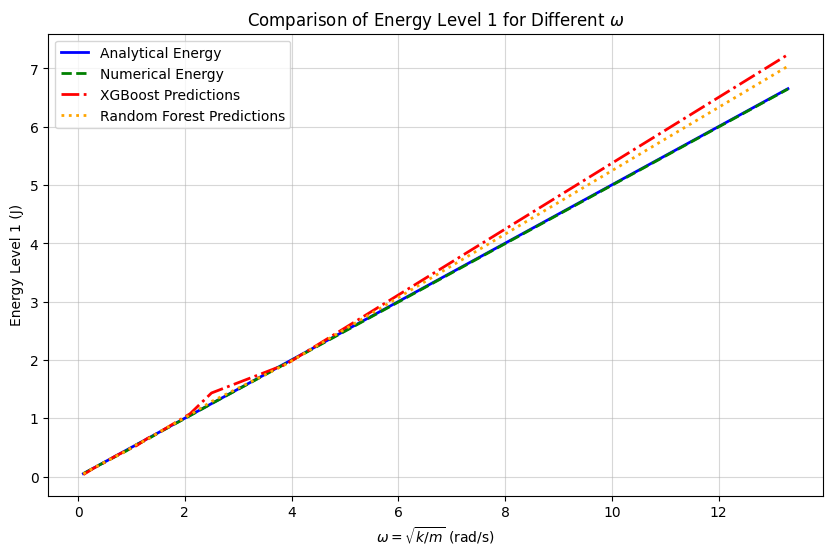

In [84]:
# Calculate analytical, numerical, and predicted energies
analytical_energy = [analytical_energy_levels(m, k)[0] for m, k in zip(m_values, k_values)]
numerical_energy = [solve_schrodinger_1d(m, k)[0] for m, k in zip(m_values, k_values)]
XGB_energy = multi_output_model.predict(input_features)[:, 0]  # Energy level 1 predictions
RF_energy = rf_model.predict(input_features)[:, 0]             # Energy level 1 predictions

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(omega_values, analytical_energy, label="Analytical Energy", color='blue', linewidth=2)
plt.plot(omega_values, numerical_energy, label="Numerical Energy", color='green', linestyle='--', linewidth=2)
plt.plot(omega_values, XGB_energy, label="XGBoost Predictions", color='red', linestyle='-.', linewidth=2)
plt.plot(omega_values, RF_energy, label="Random Forest Predictions", color='orange', linestyle=':', linewidth=2)

plt.xlabel(r"$\omega = \sqrt{k/m}$ (rad/s)")
plt.ylabel("Energy Level 1 (J)")
plt.title("Comparison of Energy Level 1 for Different $\omega$")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

Again we can see that both the models follow the numerical line closely at lower omega valuee, still even at lower omega Random Forest looks to follow it more closely. But the problem starts when we increase the omega (sqrt(k/m)). As explained before due to lack of training data in the higher omega range, both the models deviate vastly at higher omega values but still Random Forest does a better job at keeping itself somewhat close to the numerical line as compared to the XGBoost model.
***

***
Now that we have looked at the lesser complex models like random forest and XGBoost in predicting the energy levels for harmonic oscillator, We now turn our attention to a more complex model like Physics-Informed Neural Network (PINN), espcially because PINNs are often better suited for physics regression problems than traditional machine learning models like XGBoost or Random Forest, especially when the problem involves physical constraints this is because PINNs directly encode the governing physical equations (here, Schrödinger's equation) into the loss function, this ensures the model respects the known physical properties of the system, leading to solutions that are consistent with the laws of physics. Meanwhile traditional machine learning models like XGBoost or Random Forest are purely data-driven models. They do not understand or incorporate physical laws, which may lead to physically invalid predictions, especially in regions where training data is sparse as we saw in the case of larger omega values where training data was sparse.

In [17]:
# Define the PINN class
class EnergyPINN(Model):
    def __init__(self):
        super(EnergyPINN, self).__init__()
        self.hidden_layers = [
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(1, activation=None)  # Output: Energy level
        ]

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return x

Here we have defined a fully connected neural network with 3 hidden layers, each having 64 neurons and a 'tanh' activation with the final layer having 1 neuron giving the energy level.
***

In [18]:
# Generate synthetic training data
def generate_data(num_samples=1000):
    masses = np.random.uniform(0.1, 50, num_samples)
    spring_constants = np.random.uniform(0.1, 50, num_samples)
    omega = np.sqrt(spring_constants / masses)
    energies = 0.5 * omega  # Analytical formula for the first energy level
    inputs = np.vstack((masses, spring_constants)).T
    return inputs, energies

# Prepare data
X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(200)

# Convert data to float32 before creating TensorFlow datasets
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

As PINNs are computationally very expensive as compare to tradional ML models hence we cannot use the existing quantum_data.csv file which we created for the training of XGBoost and Random Forest. Hence in this cell we have created a lighter dataset, for the ground state energy level only, for PINN to train on. Of course if we would have used quantum_data.csv file then the model would have been even better but it is computationally very expensive especially for my laptop specs :)
***

In [19]:
# Initialize the model and optimizer
pinn = EnergyPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

In our model we have used Adam optimizer to minimize the loss and Mean Squared Error (MSE) as the loss function used to measure prediction accuracy.
***

In [20]:
# Training step
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = pinn(inputs)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))
    return loss

# Training loop
epochs = 3000
for epoch in range(epochs):
    for inputs, targets in train_dataset:
        loss = train_step(tf.convert_to_tensor(inputs, dtype=tf.float32),
                          tf.convert_to_tensor(targets, dtype=tf.float32))
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")

Epoch 0: Loss = 0.003642
Epoch 500: Loss = 0.000007
Epoch 1000: Loss = 0.000008
Epoch 1500: Loss = 0.000003
Epoch 2000: Loss = 0.000003
Epoch 2500: Loss = 0.000038


Here we have used gradient descent optimization for the training process of PINN.
***

In [21]:
# Evaluate on test data
predictions = []
true_energies = []
for inputs, targets in test_dataset:
    preds = pinn(tf.convert_to_tensor(inputs, dtype=tf.float32))
    predictions.extend(preds.numpy())
    true_energies.extend(targets.numpy())

# Convert results to numpy arrays
predictions = np.array(predictions).flatten()
true_energies = np.array(true_energies)

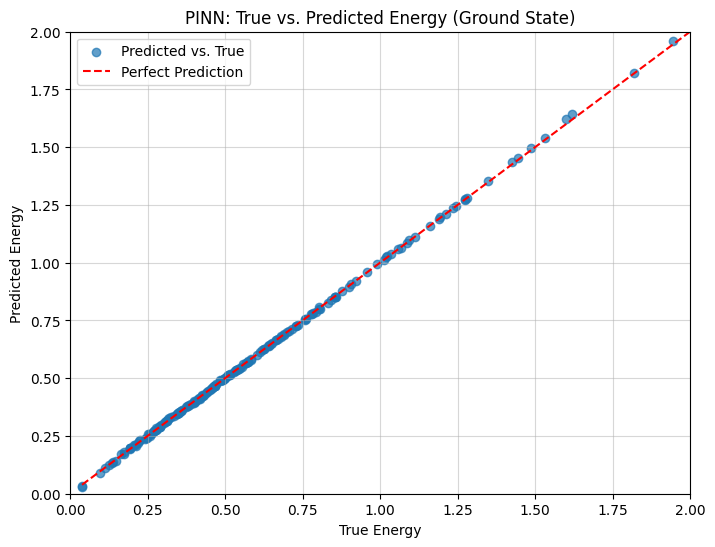

In [24]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(true_energies, predictions, alpha=0.7, label="Predicted vs. True")
plt.plot([min(true_energies), max(true_energies)],
         [min(true_energies), max(true_energies)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("True Energy")
plt.ylabel("Predicted Energy")
plt.title("PINN: True vs. Predicted Energy (Ground State)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

As we can see that even at the higher energy values of the ground state, PINN is closely following the perfect prediction line, which was expected from the model as it is particulary accurate even in those areas where training data is sparse.
***

<>:46: SyntaxWarning: invalid escape sequence '\o'
<>:46: SyntaxWarning: invalid escape sequence '\o'
C:\Users\divya\AppData\Local\Temp\ipykernel_5444\3711885171.py:46: SyntaxWarning: invalid escape sequence '\o'
  plt.title("Comparison of Energy Level 1 for Different $\omega$", fontsize=16)


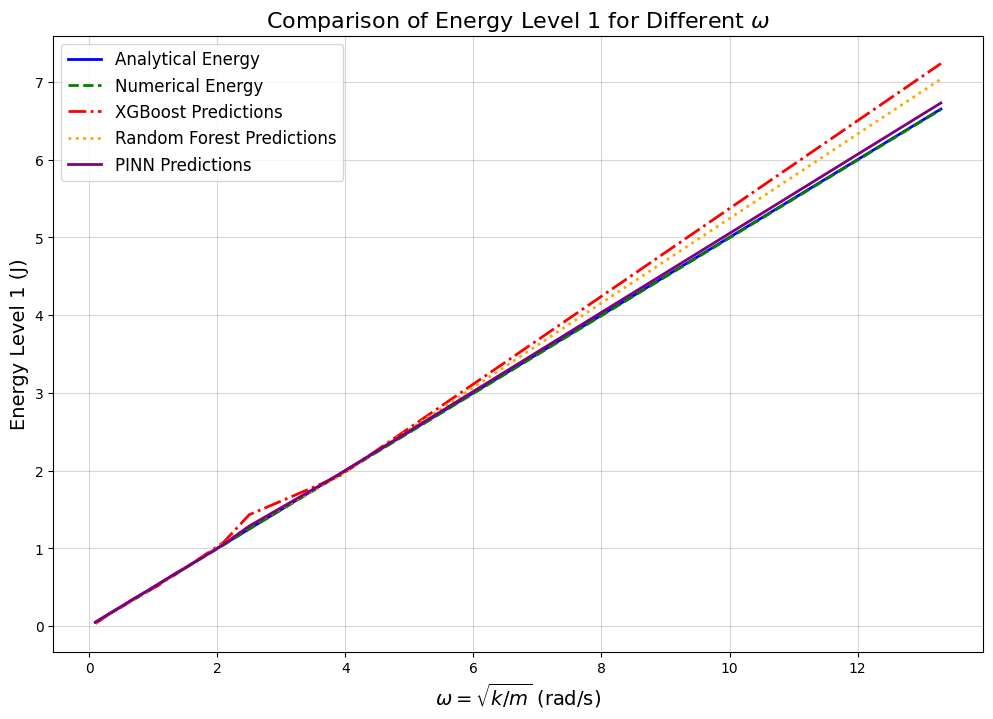

In [ ]:
# Predictions using PINN
pinn_predictions = []
for m, k in zip(m_values, k_values):
    sample_input = tf.convert_to_tensor([[m, k]], dtype=tf.float32)
    pinn_prediction = pinn(sample_input).numpy()[0]  # Predict energy level 1
    pinn_predictions.append(pinn_prediction)
pinn_energy = np.array(pinn_predictions)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(omega_values, analytical_energy, label="Analytical Energy", color='blue', linewidth=2)
plt.plot(omega_values, numerical_energy, label="Numerical Energy", color='green', linestyle='--', linewidth=2)
plt.plot(omega_values, XGB_energy, label="XGBoost Predictions", color='red', linestyle='-.', linewidth=2)
plt.plot(omega_values, RF_energy, label="Random Forest Predictions", color='orange', linestyle=':', linewidth=2)
plt.plot(omega_values, pinn_energy, label="PINN Predictions", color='purple', linestyle='-', linewidth=2)

plt.xlabel(r"$\omega = \sqrt{k/m}$ (rad/s)", fontsize=14)
plt.ylabel("Energy Level 1 (J)", fontsize=14)
plt.title("Comparison of Energy Level 1 for Different $\omega$", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()


As we can see what we expected earlier came true in our results also. PINN is able to out perform both the traditional machine learning models XGBoost and Random Forest. It is able to perform better in higher values of omega and closely follow the numerical data line. This is the situation when we have used the lighter training dataset with lesser number of training cases, if we would have used a better training dataset then the performance of the PINN model would have been even better. Hence we can conclude that PINNs can be used for predicting the energy levels from m and k values relieving us from doing the computationally expensive work of finding the numerical solutions again and again.
***

In [148]:
# Mean Square error of all models for analytical comparison between their performance

mse_rf = mean_squared_error(numerical_energy,RF_energy)
mse_xgb = mean_squared_error(numerical_energy,XGB_energy)
mse_pinn = mean_squared_error(numerical_energy,pinn_energy)

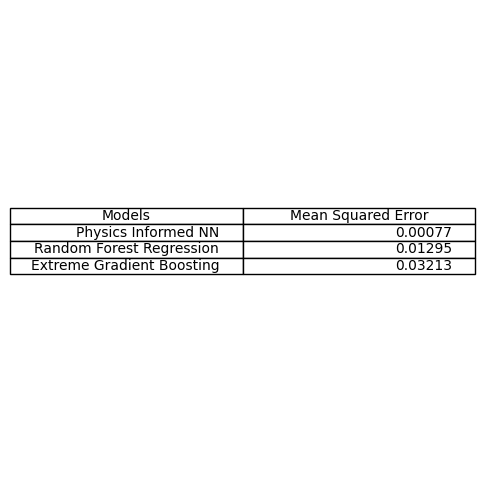

<Figure size 600x100 with 0 Axes>

In [175]:


# Data for the table
column_1 = ['Physics Informed NN', 'Random Forest Regression', 'Extreme Gradient Boosting']
column_2 = [round(mse_pinn,5), round(mse_rf,5), round(mse_xgb,5)]  # Replace with your values

# Combine the data into a list of rows
data = list(zip(column_1, column_2))

fig, ax = plt.subplots(figsize=(6, 6))  # Adjust the size here

# Hide axes as we don't need them for the table
ax.axis('off')

# Create the table
table = ax.table(cellText=data, colLabels=['Models', 'Mean Squared Error'], loc='center')

plt.figure(figsize=(6, 1))

# Display the table
plt.show()

As we can see the data of Mean Squared error of the models agrees with our interpretation of the above plot.
***

***
PINNs worked wonders for predicting the energy levels of a harmonic oscillator but can we go even further with this model? As we know wavefunction is an important and integral part of all quantum systems as it provides a complete description of the quantum system, encapsulating all the information about a particle's state. Knowing the wavefunctions enables us to compute the probabilities, expectation values, and physical observables (e.g., position, momentum, energy). These insights are critical for interpreting experimental results. Predicting wavefunctions also allows us to analyze phenomena like tunneling, interference, and energy quantization. In the below cells of code we try to use PINN to predict the wavefunction of a 1D harmonic oscillator system in ground state.

In [142]:
from tensorflow.keras import models

In [143]:
# Constants
hbar = 1.0
m = 1.0
k = 1.0
omega = np.sqrt(k / m)

# Generate x values
x_values = np.linspace(-5, 5, 200).reshape(-1, 1)

In [144]:
# Define the Neural Network
def create_pinn():
    model = models.Sequential([
        layers.InputLayer(input_shape=(1,)),
        layers.Dense(64, activation='tanh'),
        layers.Dense(64, activation='tanh'),
        layers.Dense(1, activation=None)  # Output: ψ(x)
    ])
    return model

model = create_pinn()

E = 0.5 * hbar * omega  # Example energy level (ground state)

# Physics-Informed Loss Function
def pinn_loss(model, x):
    with tf.GradientTape() as tape1:
        tape1.watch(x)
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            psi = model(x)  # ψ(x)
        dpsi_dx = tape2.gradient(psi, x)  # ∂ψ/∂x
    d2psi_dx2 = tape1.gradient(dpsi_dx, x)  # ∂²ψ/∂x²

    # Schrödinger equation residual
    potential = 0.5 * k * x**2
    schrodinger_residual = -hbar**2 / (2 * m) * d2psi_dx2 + potential * psi - E * psi

    # Physics Loss
    physics_loss = tf.reduce_mean(tf.square(schrodinger_residual))

    # Boundary Condition Loss (ψ → 0 at boundaries)
    boundary_loss = tf.reduce_mean(tf.square(model(tf.constant([[-5.0], [5.0]]))))

    return physics_loss + boundary_loss

Here first we have defined a neural network with 2 hidden layer each with 64 neurons. The output of this is c * psi(x). I have multiplied c here because here the scrodinger equation which is followed by psi(x) also has c * psi(x) as its solution, where c is a constant. After this we have defined the loss function which uses the physical constraint of the schrodinger equation as well as the boundary condition that the wavefunction must tend to 0 at boundaries. These conditions will make sure that our solutions are consistent with the laws of physics. This incorporation of phyical laws into in the loss function is what differentiates PINNs from Normal Neural Networks as a standard neural network typically focuses solely on learning from the data without any explicit knowledge of the underlying physical processes.
***

In [145]:
# Training Loop
E = 0.5 * hbar * omega  # Example energy level (ground state)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        loss = pinn_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training
epochs = 5000
for epoch in range(epochs):
    loss = train_step(tf.constant(x_values, dtype=tf.float32))
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")


Epoch 0: Loss = 2.279564
Epoch 500: Loss = 0.000013
Epoch 1000: Loss = 0.000005
Epoch 1500: Loss = 0.000003
Epoch 2000: Loss = 0.000002
Epoch 2500: Loss = 0.000001
Epoch 3000: Loss = 0.000001
Epoch 3500: Loss = 0.000001
Epoch 4000: Loss = 0.000001
Epoch 4500: Loss = 0.000006


Here we have set E to the ground state energy of a 1D harmonic oscillator. Also we have used gradient descent for the training purpose of the PINN model.
***

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


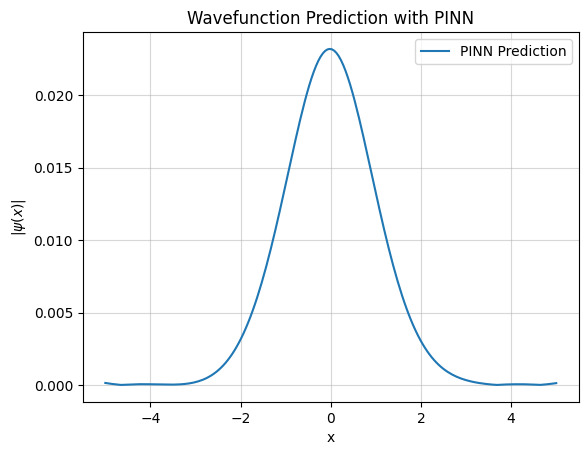

In [146]:
# Visualization
import matplotlib.pyplot as plt

psi_pred = model.predict(x_values)

plt.plot(x_values, abs(psi_pred), label='PINN Prediction')
plt.title("Wavefunction Prediction with PINN")
plt.xlabel("x")
plt.ylabel(r"$|\psi(x)|$")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

This is the predicted wave function by the PINN model. Lets us now look if it is correct or not by comparing it with the the actual solution of the schrodinger equation of 1D harmonic oscillator for ground state i.e. hermite polynomials.
***

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\divya\AppData\Local\Temp\ipykernel_5444\2141864996.py:17: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_values, abs(psi_actual), label="Analytical $\psi_0(x)$", color="blue", linewidth=2)
C:\Users\divya\AppData\Local\Temp\ipykernel_5444\2141864996.py:18: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(x_values, abs(psi_pred_normalized), label="Predicted $\psi_0(x)$ (PINN)", color="red", linestyle="--", linewidth=2)


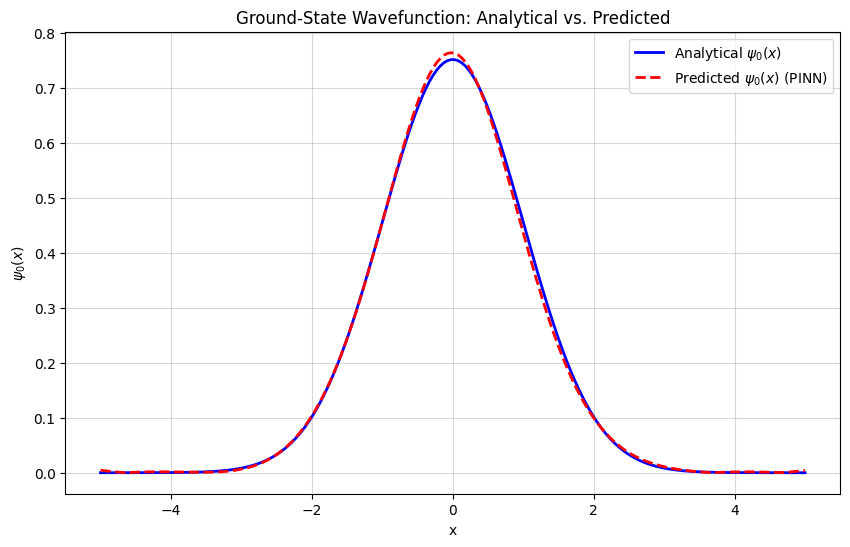

In [147]:
# Analytical ground-state wavefunction
def analytical_psi_0(x):
    normalization = (m * omega / (np.pi * hbar))**0.25
    return normalization * np.exp(-m * omega * x**2 / (2 * hbar))

# Predict with PINN
psi_pred = model.predict(x_values).flatten()

# Normalize the predicted wavefunction
psi_pred_normalized = psi_pred / np.sqrt(np.sum(psi_pred**2) * (x_values[1] - x_values[0]))

# Analytical wavefunction
psi_actual = analytical_psi_0(x_values.flatten())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_values, abs(psi_actual), label="Analytical $\psi_0(x)$", color="blue", linewidth=2)
plt.plot(x_values, abs(psi_pred_normalized), label="Predicted $\psi_0(x)$ (PINN)", color="red", linestyle="--", linewidth=2)
plt.title("Ground-State Wavefunction: Analytical vs. Predicted")
plt.xlabel("x")
plt.ylabel(r"$\psi_0(x)$")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

First of all we have normalized the predicted psi(x) to get rid of the constant c factor that we talked about earlier. Then we have plotted |psi(x)| vs x. As we can see the predicted psi(x) closely follows the analytical psi(x) througout the domain. This showcases the PINN model's ability to predict wavefunctions for various quantum systems thus giving us the ability to analytically analyze even the most complex quantum systems by predicting its wavefunction using such ML models.